<a href="https://colab.research.google.com/github/GenZBoy/Automobile-Sales-database/blob/main/plantdiseasepredictionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-learn


     |████████████████████████████████| 7.9MB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 33.0MB 1.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import kagglehub

# Download latest version
path = "/Users/arpan/Downloads/Test"

print("Path to dataset files:", path)

Path to dataset files: /Users/arpan/Downloads/Test


In [ ]:
pip install torch torchvision torchaudio


  Using cached https://files.pythonhosted.org/packages/b9/18/d97cdc571b4cb90c0d3613cffb19a55ef1e48e74e0c5a6c293e97234b7d3/torch-1.13.1-cp37-none-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f3/f8/c4601983a1ccb75588e77de2fd3932170cc24bdf5839565af839e9fa9729/torchvision-0.14.1-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2b/f2/b0109eaf73a15c20901720e9bde572d1cac2f6b129db09290052deaeb2ef/torchaudio-0.13.1-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/7d/01404982db598f271ac7c0d0207860f60ab9288cfacce9872eb567cfbfe3/Pillow-9.5.0-cp37-cp37m-macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/32/dd/43d8b2b2ebf424f6555271a4c9f5b50dc3cc0aafa66c72b4d36863f71358/numpy-1.21.6-cp37-cp37m-maco

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
num_epochs = 20
learning_rate = 0.0005
batch_size = 32
weight_decay = 1e-4
num_classes = 3  # Example: Number of plant diseases

# Transformations (Data Augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224),
    transforms.Grayscale(num_output_channels=3),  # 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = datasets.ImageFolder(root=path, transform=transform)

# Split dataset into train and test sets
train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class EfficientNet_NeuralNet(nn.Module):
    def __init__(self, num_diseases):
        super(EfficientNet_NeuralNet, self).__init__()
        self.efficientnet = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
        
        # Fine-tune some layers
        for param in self.efficientnet.features[:6].parameters():
            param.requires_grad = False
        
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_diseases)
        )

    def forward(self, x):
        return self.efficientnet(x)

In [ ]:
model = EfficientNet_NeuralNet(num_classes).to(device)

# Loss and Optimizer with Weight Decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /Users/arpan/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:15<00:00, 2.44MB/s]


In [ ]:
# Training loop
def train_model():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [37]:
def evaluate_model():
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Append the labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate accuracy
    print(f'Accuracy: {100 * correct / total:.2f}%')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 91.30%


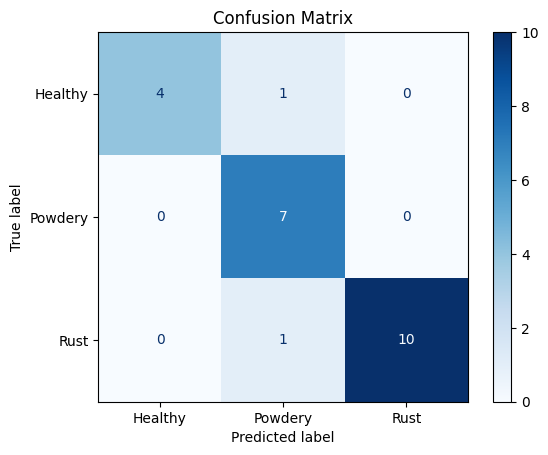

In [38]:
if __name__ == "__main__":
    
    evaluate_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /Users/arpan/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1076)>